In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../../data/SPY_5y_daily.csv', header=[0, 1], index_col=0, parse_dates=True)
data.columns = data.columns.droplevel(1)

df_base = data[['Close']].copy()
df_base['Return'] = data['Close'].pct_change()

df_base.head(2)

Price,Close,Return
Date,,
2021-01-19,353.460846,NaN
2021-01-20,358.352234,0.013839


In [3]:
fast_params = range(10, 50, 5)
slow_params = range(60, 210, 10)

sharpe_matrix = np.zeros((len(fast_params), len(slow_params)))
sharpe_matrix.size

120

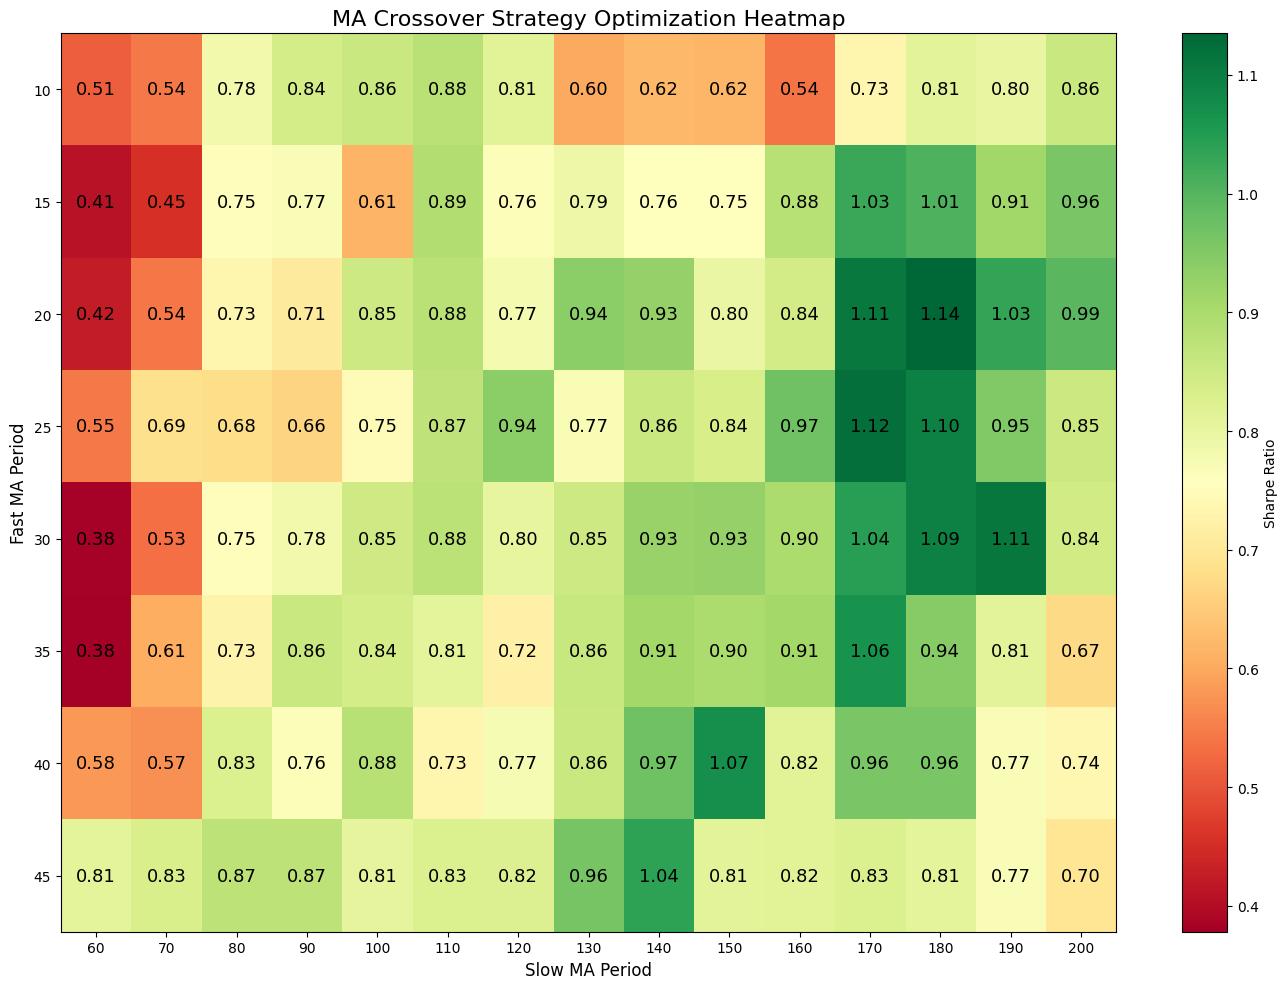

In [4]:
for i, f in enumerate(fast_params):
    for j, s in enumerate(slow_params):

        ma_fast = df_base['Close'].rolling(window=f).mean()
        ma_slow = df_base['Close']. rolling(window=s).mean()

        signal = np.where(ma_fast > ma_slow, 1, 0)
        
        signal = np.roll(signal, 1)
        signal[0] = 0

        strategy_returns = signal * df_base['Return']
        valid_returns = strategy_returns[s:]

        if valid_returns.std() > 0:
            sharpe = (valid_returns.mean() / valid_returns.std()) * np.sqrt(252)
        else:
            sharpe = 0

        sharpe_matrix[i, j] = sharpe

plt.figure(figsize=(14, 10))
plt.imshow(sharpe_matrix, cmap='RdYlGn', interpolation='nearest', aspect='auto')

plt.colorbar(label='Sharpe Ratio')
plt.title('MA Crossover Strategy Optimization Heatmap', fontsize=16)

# Eksen Etiketleri
plt.xticks(np.arange(len(slow_params)), list(slow_params))
plt.xlabel('Slow MA Period', fontsize=12)

plt.yticks(np.arange(len(fast_params)), list(fast_params))
plt.ylabel('Fast MA Period', fontsize=12)

# Hücrelerin içine değerleri yaz
for i in range(len(fast_params)):
    for j in range(len(slow_params)):
        # Yazı rengini arka plana göre ayarla (Koyu yere beyaz, açık yere siyah)
        val = sharpe_matrix[i, j]
        # color = "white" if val < 0.3 or val > 0.8 else "black"
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", color='black', fontsize=13)

plt.tight_layout()
plt.show()


C:\Users\kiyar\AppData\Local\Temp\ipykernel_27792\3715250807.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_opt['Signal'][0] = 0
C:\Users\kiyar\AppData\Local\Temp\ipykernel_27792\3715250807.py:10: SettingWithCopyWarning: 
A value is

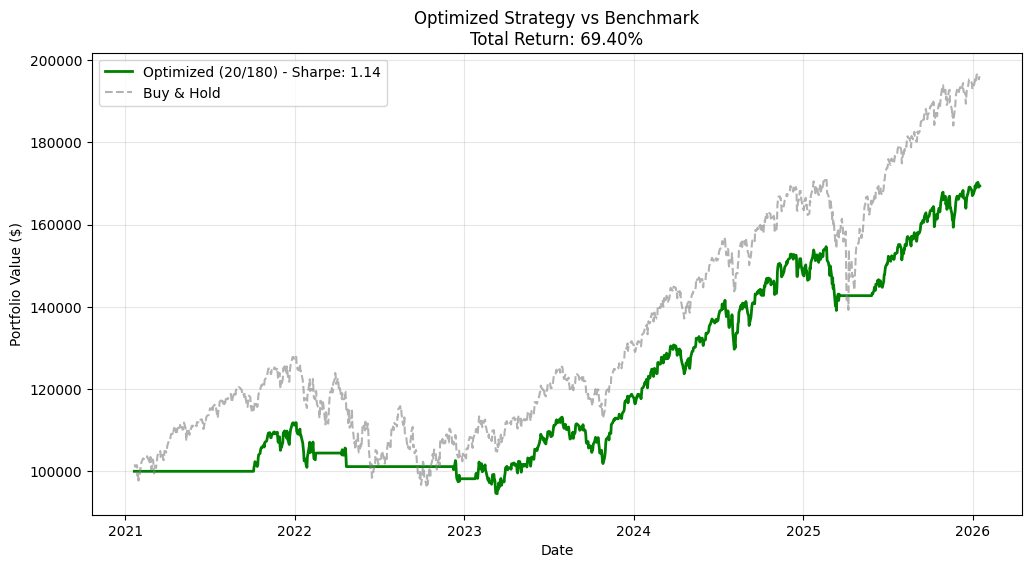

In [5]:
best_fast = 20
best_slow = 180

df_opt = df_base.copy()
df_opt['MA_Fast'] = df_opt['Close'].rolling(window=best_fast).mean()
df_opt['MA_Slow'] = df_opt['Close'].rolling(window=best_slow).mean()

df_opt['Signal'] = np.where(df_opt['MA_Fast'] > df_opt['MA_Slow'], 1, 0)
df_opt['Signal'] = np.roll(df_opt['Signal'], 1) # Look-ahead bias önlemi
df_opt['Signal'][0] = 0

df_opt['Strategy_Return'] = df_opt['Signal'] * df_opt['Return']

df_opt['Strategy_Equity'] = 100_000 * (1 + df_opt['Strategy_Return']).cumprod()
df_opt['BuyHold_Equity'] = 100_000 * (1 + df_opt['Return']).cumprod()

valid_ret = df_opt['Strategy_Return'][best_slow:]
sharpe_opt = (valid_ret.mean() / valid_ret.std()) * np.sqrt(252)
total_ret_opt = (df_opt['Strategy_Equity'].iloc[-1] / 100_000) - 1

plt.figure(figsize=(12, 6))

plt.plot(df_opt['Strategy_Equity'], label=f'Optimized ({best_fast}/{best_slow}) - Sharpe: {sharpe_opt:.2f}', color='green', linewidth=2)
plt.plot(df_opt['BuyHold_Equity'], label='Buy & Hold', color='gray', linestyle='--', alpha=0.6)

plt.title(f'Optimized Strategy vs Benchmark\nTotal Return: {total_ret_opt:.2%}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
fast_window = 20
slow_window = 180
stop_loss_pct = 0.10

In [7]:
df_final = df_base.copy()
df_final['MA_Fast'] = df_base['Close'].rolling(fast_window).mean()
df_final['MA_Slow'] = df_base['Close'].rolling(slow_window).mean()
df_final.dropna(inplace=True)

In [8]:
capital = 100_000
equity_curve = [capital]
position = 0
entry_price = 0
highest_price = 0
stop_price = 0

trades = []

In [9]:
for i in range(len(df_final)):
    today = df_final.iloc[i]
    price = today['Close']
    date = today.name

    ma_buy = df_final['MA_Fast'] > df_final['MA_Slow']
    ma_sell = df_final['MA_Fast'] < df_final['MA_Slow']


    if position > 0:

        if price > highest_price:
            highest_price = price
            stop_price = highest_price * (1 - stop_loss_pct)

        if price < stop_price:
            capital = position * price
            trades.append({
                'Date': date,
                'Type' : 'STOP LOSS',
                'Price' : price,
                'Return' : (price - entry_price) / entry_price
            })

            position = 0
            equity_curve.append(capital)
            continue

    if position == 0 and ma_buy[i]:
        position = capital / price
        entry_price = price
        highest_price = price
        stop_price = highest_price * (1 - stop_loss_pct)
        capital = 0

    elif position > 0 and ma_sell[i]:
        capital = position * price
        trades.append({
            'Date' : date,
            'Type' : 'MA EXIT',
            'Price' : price,
            'Return' : (price - entry_price) / entry_price
        })
        position = 0

    if position > 0:
        equity_curve.append(position * price)
    else:
        equity_curve.append(capital)

C:\Users\kiyar\AppData\Local\Temp\ipykernel_27792\224362993.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if position == 0 and ma_buy[i]:
C:\Users\kiyar\AppData\Local\Temp\ipykernel_27792\224362993.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif position > 0 and ma_sell[i]:


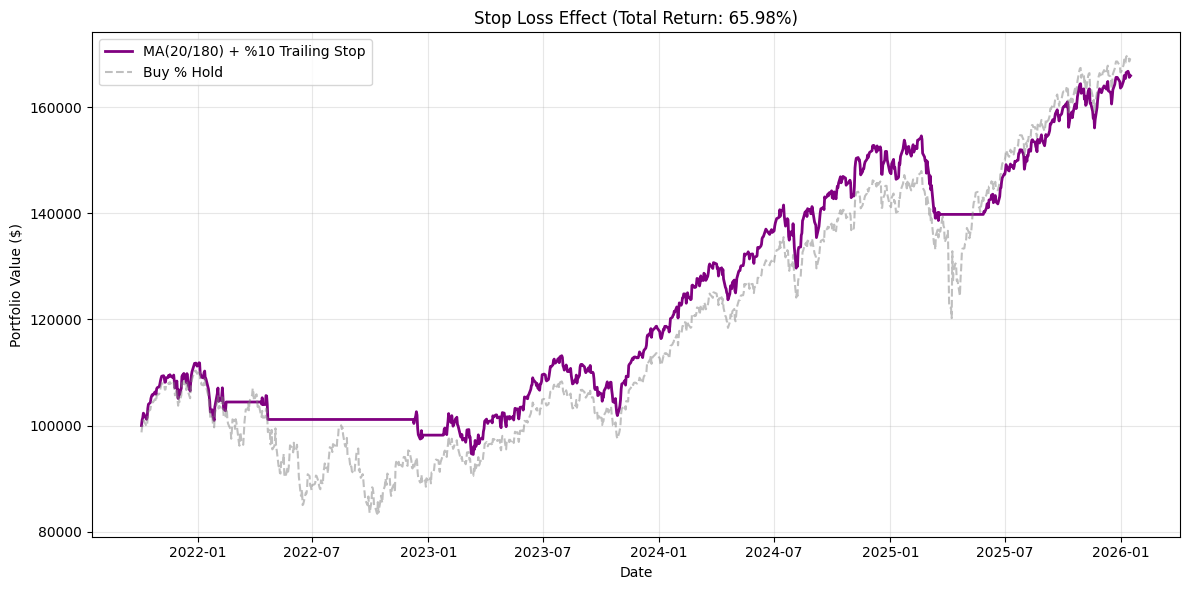

Total Trades: 5
Stop Loss Count: 1


In [10]:
equity_curve = equity_curve[1:]
df_final['Strategy_Equity'] = equity_curve

total_ret = (df_final['Strategy_Equity'].iloc[-1] / 100_000) - 1

plt.figure(figsize=(12, 6))

plt.plot(df_final['Strategy_Equity'], label=f"MA({fast_window}/{slow_window}) + %10 Trailing Stop", color='purple', linewidth=2)

buy_hold = 100_000 * (1 + df_final['Return']).cumprod()
plt.plot(buy_hold, label='Buy % Hold', color='gray', linestyle='--', alpha=0.5)

plt.title(f'Stop Loss Effect (Total Return: {total_ret:.2%})')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Total Trades: {len(trades)}')

stops = [t for t in trades if t['Type'] == 'STOP LOSS']
print(f"Stop Loss Count: {len(stops)}")

In [11]:
strategy_rets = df_final['Strategy_Equity'].pct_change()
strat_sharpe = (strategy_rets.mean() / strategy_rets.std()) * np.sqrt(252)

bench_sharpe = (df_final['Return'].mean() / df_final['Return'].std()) * np.sqrt(252)

print(f"MA Cross + TSL : {strat_sharpe:.2f}")
print(f"Benchmark (B&H) : {bench_sharpe:.2f}")

MA Cross + TSL : 1.10
Benchmark (B&H) : 0.78


In [ ]:
import time

def run_backtest_with_loop(df, fast_w=20, slow_w=180, stop_pct=0.10):
    local_df = df.copy()
    # MA hesapları (Vectorized - Hızlı)
    local_df['MA_Fast'] = local_df['Close'].rolling(fast_w).mean()
    local_df['MA_Slow'] = local_df['Close'].rolling(slow_w).mean()
    local_df.dropna(inplace=True)
    
    # Loop değişkenleri
    capital = 100_000
    position = 0
    entry_price = 0
    highest_price = 0
    stop_price = 0
    equity_curve = [capital]
    
    # Pre-calculate signals to numpy arrays for speed 
    # _________________________(DataFrame access is slower inside loop)_________________________
    close_arr = local_df['Close'].values
    ma_fast_arr = local_df['MA_Fast'].values #                  <------------------------
    ma_slow_arr = local_df['MA_Slow'].values
    dates = local_df.index
    
    # THE BOTTLENECK: Loop                      PANDAS DATAFRAME YERINE NUMPY ARRAYLERI ILE
    for i in range(len(local_df)): #            AYNI ISI COK DAHA HIZLI BIR SEKILDE YAPTIK !
        price = close_arr[i]
        
        # Sinyal kontrolleri
        ma_buy = ma_fast_arr[i] > ma_slow_arr[i] #             <------------------------
        ma_sell = ma_fast_arr[i] < ma_slow_arr[i]
    # ___________________________________________________________________________________________
        if position > 0:
            if price > highest_price:
                highest_price = price
                stop_price = highest_price * (1 - stop_pct)
            
            if price < stop_price:
                # Stop Loss Exit
                capital = position * price
                position = 0
                equity_curve.append(capital)
                continue
                
        if position == 0 and ma_buy:
            position = capital / price
            entry_price = price
            highest_price = price
            stop_price = highest_price * (1 - stop_pct)
            capital = 0
            
        elif position > 0 and ma_sell:
            # MA Exit
            capital = position * price
            position = 0
        
        if position > 0:
            equity_curve.append(position * price)
        else:
            equity_curve.append(capital)
            
    return equity_curve

# Hız Testi
start_time = time.time()
run_backtest_with_loop(df_base)
end_time = time.time()

print(f"Backtest süresi: {(end_time - start_time):.4f} saniye")

Backtest süresi: 0.0032 saniye
